In [8]:
import gym
import tensorflow as tf 
#tf.compat.v1.enable_eager_execution()
from gym import error, spaces, utils
from gym.utils import seeding
from lstm_node_tranistion_model import CAGENodeTranistionModelLSTM
from reward_model import CAGERewardModel
from tensorflow.keras.models import Model
import numpy as np
from tqdm import trange

/home/adamprice/.local/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [9]:
#Get unique states 
data_path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/Notebooks/logs/PPO/no_decoy_200000'
state = np.load(data_path + '/data/state.npy')
unique_states = np.unique(state, axis=0)
unique_states = list(unique_states)

In [28]:
init_state = np.array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
                                    0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
                                    1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
                                    1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.])

any((init_state==unique_states).all(1))

True

In [4]:
sequence_length = 3
state_len = 91
num_actions = 41
encoding_len = state_len + num_actions
NUM_NODES = 13
NODE_CLASSES = [3, 4]

class WorldMovelEnv(gym.Env):

    def __init__(self):

        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(state_len,))
        self.action_space = gym.spaces.Discrete(num_actions)

        self.step_count = 0

        # Reward Model
        self.reward_model = CAGERewardModel()
        self.reward_model.load('reward_model')

       
        self.state_tranistion_model = CAGENodeTranistionModelLSTM()
        self.state_tranistion_model.load('NodeTranistionModel')
        self.init_state = np.array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
                                    0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
                                    1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
                                    1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.])
        self.states = np.zeros((10, state_len))
        self.states[0,:] = self.init_state
        self.actions_seq = np.zeros(10)

    def step(self, action):

        self.actions_seq[-1] = action
        self.actions_seq = np.roll(self.actions_seq,1,axis=0)
        state = self.state_tranistion_model.forward(self.states, self.actions_seq)
        self.states[-1,:] = state

        reward = self.reward_model.forward(np.array([np.concatenate([self.states[0,:], state])]))
        self.states = np.roll(self.states,1,axis=0)

        done = self.step_count == 99
        if done:
            self.step_count = 0
        return state, reward, done, {'entropy': self.reward_model.get_entropy()}

    def reset(self):
        step_count = 0
        self.states = np.zeros((10, state_len))
        self.states[0,:] = self.init_state
        self.actions_seq = np.zeros(10)        

        return self.init_state

    def render(self, mode='human', close=False):
        pass

    def close(self):
        pass


def env_creator(config):
    return WorldMovelEnv()


In [5]:

WM = WorldMovelEnv()
OOD = []
ID = []
for i in trange(5):
    done = False
    s = WM.reset()
    while not done:
        action = np.random.randint(41)
        ns, r, d, i = WM.step(action)
        if any((init_state==unique_states).all(1)):
            ID.append(i['entropy'])
        else:
            OOD.append(i['entropy'])

: 

: 

ValueError: tf.enable_eager_execution must be called at program startup.

In [8]:
p = np.array([0.33,0.33,0.34])
entropy = - np.sum(np.log(p) * p) / 3
entropy

0.3661708723502399

In [7]:
p = np.array([0.98,0.01,0.01])
entropy = - np.sum(np.log(p) * p) / 3
entropy

0.0373006856303103

In [10]:
import numpy as np
ID_States = np.load('ID_States.npy')
OOD_States = np.load('OOD_States.npy')

In [11]:
state = np.concatenate([ID_States, OOD_States], axis=0)

ID_States.mean(axis=0) - OOD_States.mean(axis=0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.06596452, -0.02577605,  0.09174058,
        0.        , -0.01496674,  0.        ,  0.01496674, -0.21286031,
       -0.01912417,  0.23198448,  0.        ,  0.02383592,  0.        ,
       -0.02383592, -0.39939024,  0.03381375,  0.3655765 ,  0.        ,
        0.17100887,  0.        , -0.17100887,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.09478936,
        0.10199557, -0.00720621,  0.        ,  0.00221729,  0.        ,
       -0.00221729,  0.        , -0.0036031 ,  0.0036031 ,  0.        ,
        0.        ,  0.        ,  0.        , -0.02272727, -0.0094235 ,
        0.03215078,  0.        , -0.01025499,  0.        ,  0.01

In [7]:
ID_States.shape

(4692, 91)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import imageio
import os
from tqdm import trange
from sklearn.manifold import TSNE

In [26]:
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(state)
embedding.shape

(4950, 2)

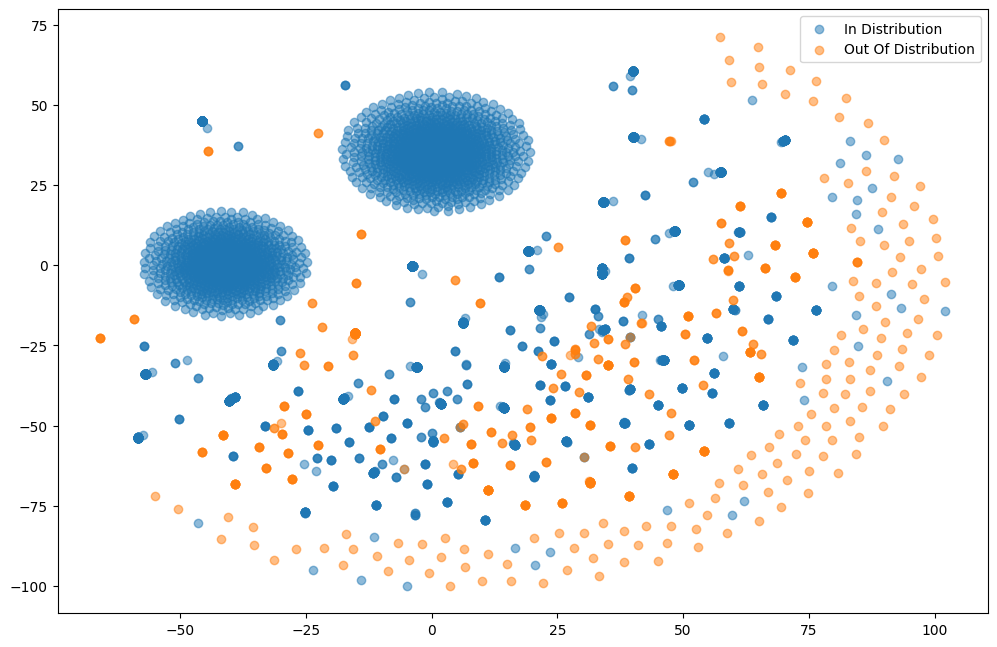

In [27]:
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(embedding[:ID_States.shape[0],0], embedding[:ID_States.shape[0],1], alpha=0.5, label='In Distribution')
plt.scatter(embedding[ID_States.shape[0]:,0], embedding[ID_States.shape[0]:,1], alpha=0.5, label='Out Of Distribution')
plt.legend()

482


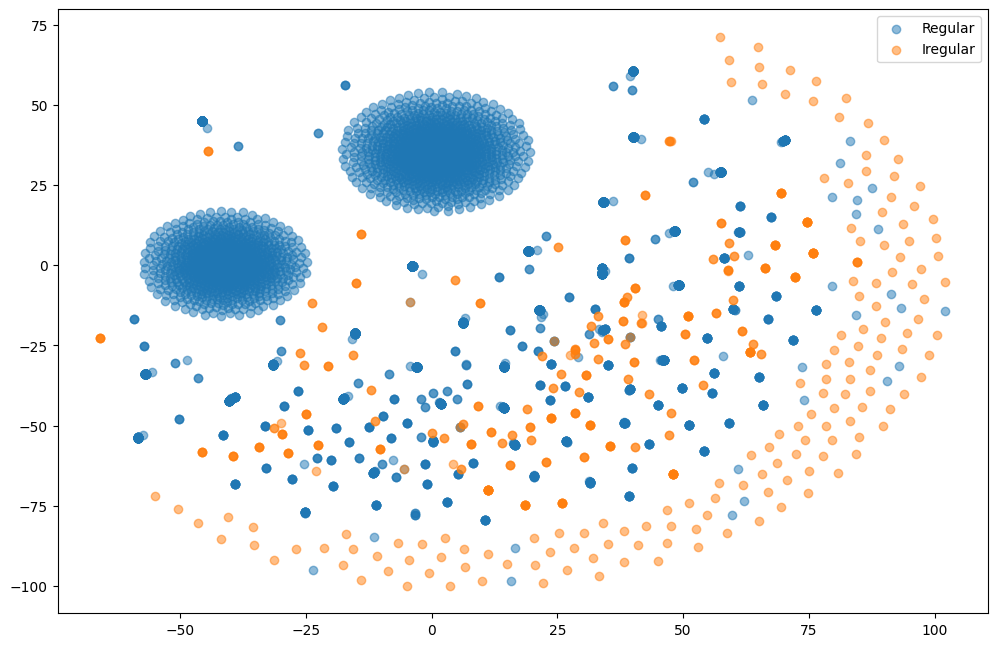

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import joblib

data_path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/Notebooks/logs/PPO/no_decoy_200000'
all_state = np.load(data_path + '/data/state.npy')
all_state = np.unique(all_state, axis=0)

# fit the model
clf = svm.OneClassSVM(nu=0.6, kernel="rbf", gamma=0.75)
clf.fit(all_state)
joblib.dump(clf, 'state_novelty.pkl', compress=9)
y_pred_train = clf.predict(state)
y_pred_train
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(embedding[y_pred_train==1][:,0], embedding[y_pred_train==1][:,1], alpha=0.5, label='Regular')
plt.scatter(embedding[y_pred_train==-1][:,0], embedding[y_pred_train==-1][:,1], alpha=0.5, label='Iregular')
plt.legend()
print(embedding[y_pred_train==-1].shape[0])

In [27]:
all_state = np.load(data_path + '/data/state.npy')
all_state = np.unique(all_state, axis=0)

In [30]:
# fit the model
from sklearn import svm
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.5)
clf.fit(all_state)

print(np.where(clf.predict(OOD_States)==-1)[0].shape[0]/OOD_States.shape[0])
print(np.where(clf.predict(all_state)==1)[0].shape[0]/all_state.shape[0])


0.03409090909090909
0.8038969201759899


In [ ]:
all_state.shape

(4773, 91)

In [ ]:
clf = joblib.load('state_novelty.pkl')
clf.predict(np.zeros((1,91)))

array([-1])

In [ ]:
embedding[y_pred_train==-1].shape

(43, 2)

In [ ]:
import umap
mapper = umap.UMAP().fit(state)

In [ ]:
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 8.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 8.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.1/973.1 kB 8.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

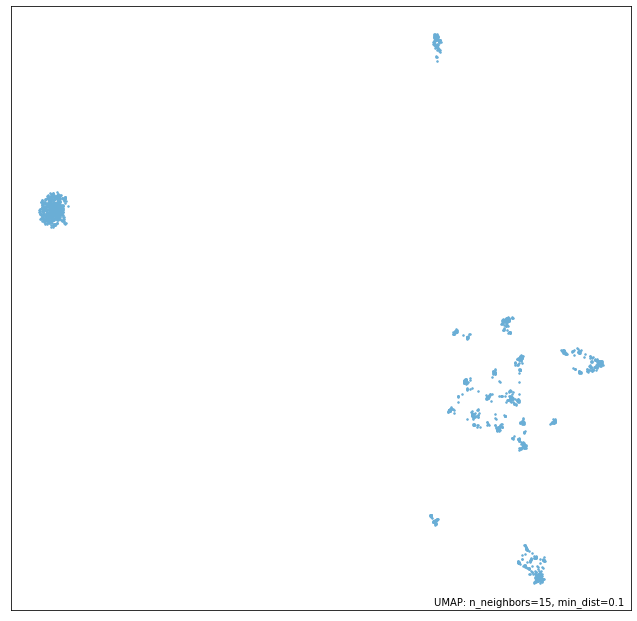

In [ ]:
import umap.plot
umap.plot.points(mapper)

In [ ]:
import numpy as np
t = np.arange(100).reshape((10,10))

t[0:3,:].reshape(-1)



array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [1]:

import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, LSTM, Input, Bidirectional, concatenate
from bisect import bisect_left
from tqdm import tqdm

STATE_LEN = 91
ACTION_LEN = 3
    
max_train_epochs = 30

def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.05)
        
x = np.zeros((100, 10))
y = np.zeros((100, 10))
for i in range(100):
    index = i % 10
    y[i, index] = 1

input_ = Input(shape=(10,))
x = Dense(32, activation='relu', name='hidden2')(input_)
#out = Dense(number_rewards, activation='softmax')(x)
out = Dense(10)(x)
base_model = Model(input_, out)

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.MeanSquaredError())#loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
with tf.device("/device:CPU:1"):
    history = base_model.fit(x, y, epochs=max_train_epochs, validation_split=0.0, 
                                    verbose=2, callbacks=[es_callback, lr_callback], batch_size=100, shuffle=True,
                                    workers=4)
    
print(base_model.predict(np.zeros((1, 10))))

: 

: 